# **Deforum Stable Diffusion (Aug 2022)**
Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team

[Github](https://github.com/CompVis/stable-diffusion)


In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla P100-PCIE-16GB, 16280 MiB, 16280 MiB


# **Environment**

In [2]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install omegaconf==2.1.1 einops==0.3.0 pytorch-lightning==1.4.2 torchmetrics==0.6.0 torchtext==0.2.3 transformers==4.19.2 kornia==0.6
!git clone https://github.com/deforum/stable-diffusion
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:39tcmalloc: large alloc 1147494400 bytes == 0x3a006000 @  0x7f394b734615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████▋           | 1055.7 MB 1.3 MB/s eta 0:07:13tcmalloc: large alloc 1434370048 bytes == 0x7e65c000 @  0x7f394b734615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████████████▏     | 

Cloning into 'stable-diffusion'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 282 (delta 27), reused 18 (delta 18), pack-reused 234
Receiving objects: 100% (282/282), 42.35 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone -q https://github.com/CompVis/taming-transformers.git /content/src/taming-transformers
  Running setup.py develop for taming-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining clip from git+https://github.com/openai/CLIP.git@mai

# **Path Variables**

In [1]:
#@markdown **Local Path Variables**
models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
  from google.colab import drive
  try:
    drive_path = "/content/drive"
    drive.mount(drive_path,force_remount=force_remount)
    models_path = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    output_path = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
  except:
    print("...error mounting drive or with drive path variables")
    print("...reverting to default path variables")
    models_path = "/content/models"
    output_path = "/content/output"

!mkdir -p $models_path
!mkdir -p $output_path

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion


# **Python Definitions**

In [15]:
from IPython import display
from tqdm.notebook import tqdm, trange

import sys, os
import argparse, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
#from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

sys.path.append('./stable-diffusion/')

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def run(params):

    # timestring
    timestring = time.strftime('%Y%m%d%H%M%S')

    # random seed
    if params["seed"] == -1:
      local_seed = np.random.randint(0,4294967295)
    else:
      local_seed = params["seed"]
    
    seed_everything(local_seed)

    if params["plms"]:
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(params["outdir"], exist_ok=True)
    outpath = params["outdir"]

    batch_size = params["n_samples"]
    n_rows = params["n_rows"] if params["n_rows"] > 0 else batch_size
    if not params["from_file"]:
        prompt = params["prompt"]
        assert prompt is not None
        data = [batch_size * [prompt]]

    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = list(chunk(data, batch_size))

    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    #base_count = len(os.listdir(sample_path))
    base_count = 0
    #grid_count = len(os.listdir(outpath)) - 1

    start_code = None
    if params["fixed_code"]:
        start_code = torch.randn([params["n_samples"], params["C"], params["H"] // params["f"], params["W"] // params["f"]], device=device)

    precision_scope = autocast if params["precision"]=="autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                #for n in trange(params["n_iter"], desc="Sampling"):
                for n in range(params["n_iter"]):
                    #for prompts in tqdm(data, desc="data"):
                    for prompts in data:
                        uc = None
                        if params["scale"] != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        c = model.get_learned_conditioning(prompts)
                        shape = [params["C"], params["H"] // params["f"], params["W"] // params["f"]]
                        samples_ddim, _ = sampler.sample(S=params["ddim_steps"],
                                                         conditioning=c,
                                                         batch_size=params["n_samples"],
                                                         shape=shape,
                                                         verbose=False,
                                                         unconditional_guidance_scale=params["scale"],
                                                         unconditional_conditioning=uc,
                                                         eta=params["ddim_eta"],
                                                         x_T=start_code)

                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

                        if not params["skip_save"]:
                            for x_sample in x_samples_ddim:
                                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                                if params["display_samples"]:
                                  display.display(Image.fromarray(x_sample.astype(np.uint8)))
                                Image.fromarray(x_sample.astype(np.uint8)).save(
                                    os.path.join(sample_path, f"{timestring}_{base_count:02}.png"))
                                base_count += 1

                        if not params["skip_grid"]:
                            all_samples.append(x_samples_ddim)

                if not params["skip_grid"]:
                    # additionally, save as grid
                    grid = torch.stack(all_samples, 0)
                    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                    grid = make_grid(grid, nrow=n_rows)

                    # to image
                    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                    if params["display_grid"]:
                        display.display(Image.fromarray(grid.astype(np.uint8)))
                    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{timestring}.png'))
                    #grid_count += 1

                toc = time.time()

    #print(f"Your samples are ready and waiting for you here: \n{outpath} \n" f" \nEnjoy.")

# **Model Checkpoints**

In [3]:
# ask for the link
download_link = "" #@param {type:"string"}

# config
if os.path.exists(models_path+'/v1-inference.yaml'):
  print(f"{models_path+'/v1-inference.yaml'} exists")
else:
  print("cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.")
  !cp ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml $models_path/.

# weights 
if os.path.exists(models_path+'/v1-inference.ckpt'):
  print(f"{models_path+'/v1-inference.ckpt'} exists")
else:
  print(f"!wget -O $models_path/v1-inference.ckpt {download_link}")
  !wget -O $models_path/v1-inference.ckpt $download_link

config = models_path+'/v1-inference.yaml'
ckpt = models_path+'/v1-inference.ckpt'

print(f"config: {config}")
print(f"ckpt: {ckpt}")

/content/drive/MyDrive/AI/models/v1-inference.yaml exists
/content/drive/MyDrive/AI/models/v1-inference.ckpt exists
config: /content/drive/MyDrive/AI/models/v1-inference.yaml
ckpt: /content/drive/MyDrive/AI/models/v1-inference.ckpt


# **Prep Model**

In [4]:
#@markdown **Load Stable Diffusion**

def load_model_from_config(config, ckpt, verbose=False):
    map_location = "cpu" #@param ["cpu", "cuda:0"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    del pl_sd
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

local_config = OmegaConf.load(f"{config}")
model = load_model_from_config(local_config, f"{ckpt}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

Loading model from /content/drive/MyDrive/AI/models/v1-inference.ckpt
Global Step: 440000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /root/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth


  0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.22.layer_norm2.weight', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.19.layer_norm2.weight', 'vision_model.encoder.layers.11.layer_norm2.bias', 'vision_model.encoder.layers.21.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.weight', 'logit_scale', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.layer_norm1.bias', 'visio

# **Run Settings**

In [21]:
def opt_params():

  #@markdown **Run Settings**
  seed = -1 #@param
  plms = True #@param {type:"boolean"}
  outdir = output_path #@param
  n_samples = 1 #@param
  n_rows = 1 #@param
  from_file = False #@param {type:"boolean"}
  prompt = "futurism" #@param {type:"string"}
  fixed_code = True #@param {type:"boolean"}
  C = 4 #@param
  H = 256 #@param
  f = 4 #@param
  W = 256 #@param
  precision = 'autocast' #@param {type:"string"}
  n_iter = 1 #@param
  scale = 7.5 #@param
  ddim_steps = 100 #@param
  ddim_eta = 0.0 #@param
  skip_save = False #@param {type:"boolean"}
  skip_grid = False #@param {type:"boolean"}
  display_samples = True #@param {type:"boolean"}
  display_grid = False #@param {type:"boolean"}

  #@markdown **Batch Settings**
  n_batch = 20 #@param

  return locals()

params = opt_params()

# **Run**

INFO:pytorch_lightning.utilities.seed:Global seed set to 891208404


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

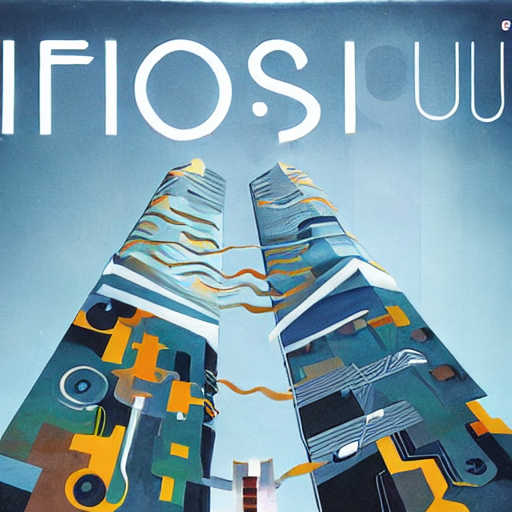

INFO:pytorch_lightning.utilities.seed:Global seed set to 3943638289


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

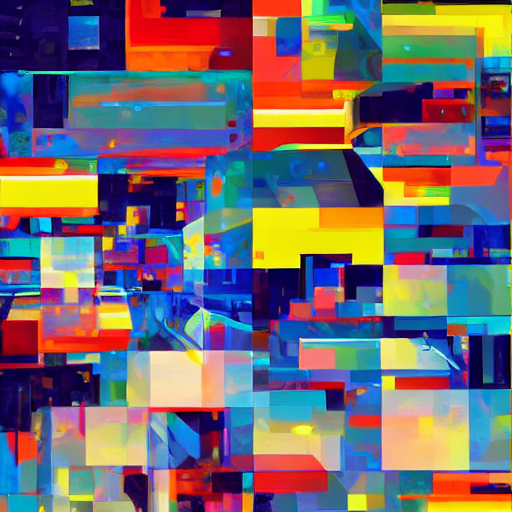

INFO:pytorch_lightning.utilities.seed:Global seed set to 1632371874


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

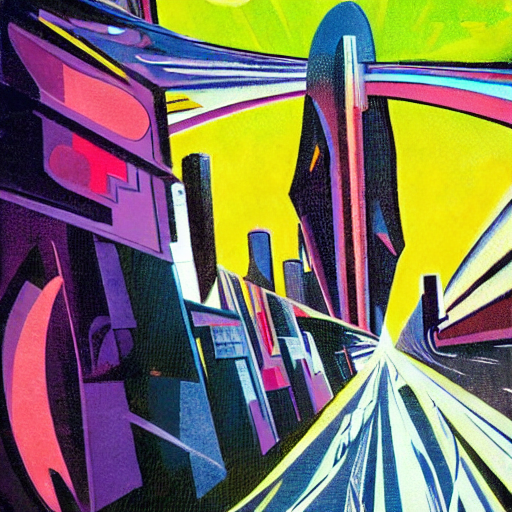

INFO:pytorch_lightning.utilities.seed:Global seed set to 2613129369


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

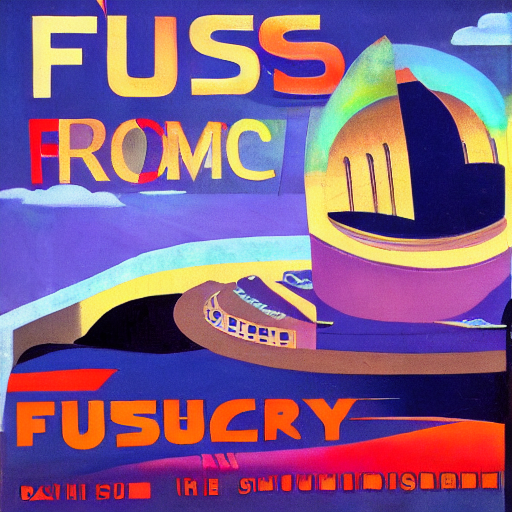

INFO:pytorch_lightning.utilities.seed:Global seed set to 4005218479


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

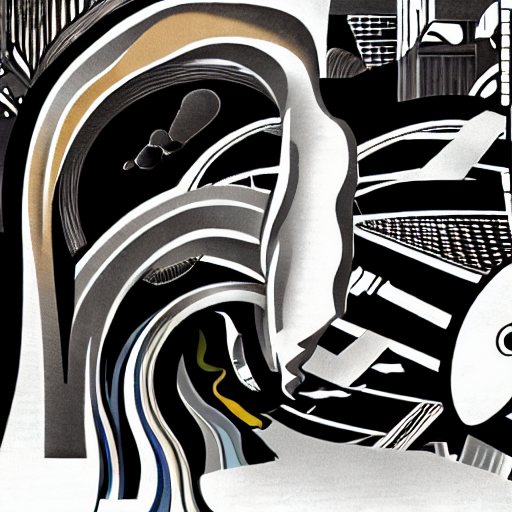

INFO:pytorch_lightning.utilities.seed:Global seed set to 1556562858


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

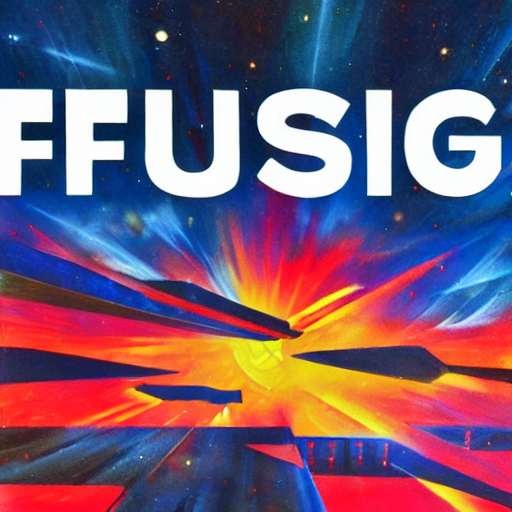

INFO:pytorch_lightning.utilities.seed:Global seed set to 2691046627


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

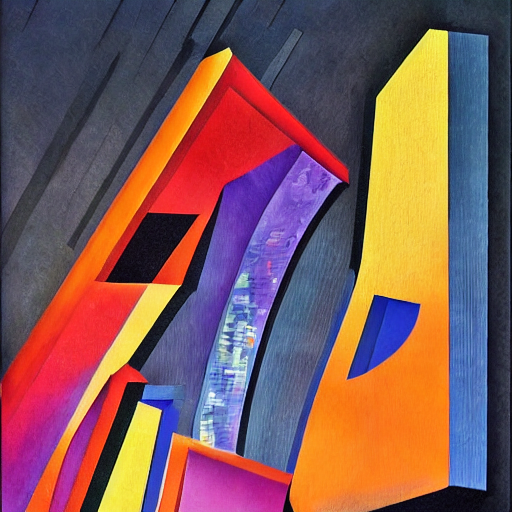

INFO:pytorch_lightning.utilities.seed:Global seed set to 476376505


Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 100 timesteps


PLMS Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#@markdown **Run**
for ii in range(params["n_batch"]):
  run(params)